# **Model For Translation From Arabic To English**

## Import Necessary Libraries

In [ ]:

print("Installing required libraries...")

# Install libraries
!pip install -q transformers datasets evaluate sacrebleu
!pip install -q sentencepiece protobuf
!pip install -q nltk pandas matplotlib

import torch
import matplotlib.pyplot as plt
from transformers import (
    MBartForConditionalGeneration,
    MBart50TokenizerFast,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from datasets import Dataset as HFDataset
import os
import evaluate
import time
import pandas as pd
import re
import nltk
import numpy as np
from pathlib import Path


## Loading Wikimatrix Dataset & Define Preprocessing Functions

In [ ]:
def load_wikimatrix_dataset(file_path):
    """Load WikiMatrix TSV file"""
    try:
        # Attempt to load the file using appropriate delimiter (TSV)
        # WikiMatrix typically uses: similarity score, English sentence, Arabic sentence
        df = pd.read_csv(file_path, sep='\t', header=None, on_bad_lines='skip')

        # Based on standard WikiMatrix format
        if len(df.columns) == 3:
            df.columns = ['similarity_score', 'english', 'arabic']
            print(f"File recognized as standard WikiMatrix dataset with similarity scores")
        elif len(df.columns) == 2:
            df.columns = ['english', 'arabic']
            print(f"File recognized as bilingual dataset without similarity scores")
        else:
            # In case the format is different
            print(f"File recognized with {len(df.columns)} columns")
            if len(df.columns) > 3:
                df = df.iloc[:, 0:3]  # Take only first 3 columns
                df.columns = ['similarity_score', 'english', 'arabic']

        # Print initial information
        print(f"Number of loaded records: {len(df)}")

        return df

    except Exception as e:
        print(f"Error reading the file: {e}")
        raise

def preprocess_arabic_text(text):
    """Preprocess Arabic text"""
    if pd.isna(text):
        return ""

    # Convert text to string if not already
    text = str(text)

    # Remove HTML and XML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove numbers in parentheses like (1) (2)
    text = re.sub(r'\(\d+\)', '', text)

    # Clean extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Trim whitespace at beginning and end
    text = text.strip()

    return text

def preprocess_english_text(text):
    """Preprocess English text"""
    if pd.isna(text):
        return ""

    # Convert text to string if not already
    text = str(text)

    # Remove HTML and XML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Trim whitespace at beginning and end
    text = text.strip()

    return text


def filter_by_length(df, min_tokens=1, max_tokens=128, min_ratio=0.2, max_ratio=5.0):

    # Count tokens in each sentence
    df['arabic_token_count'] = df['cleaned_arabic'].apply(lambda x: len(str(x).split()))
    df['english_token_count'] = df['cleaned_english'].apply(lambda x: len(str(x).split()))

    # Filter by absolute length
    length_mask = (
        (df['arabic_token_count'] >= min_tokens) &
        (df['arabic_token_count'] <= max_tokens) &
        (df['english_token_count'] >= min_tokens) &
        (df['english_token_count'] <= max_tokens)
    )

    # Filter by length ratio between source and target
    ratio_mask = (
        (df['english_token_count'] / df['arabic_token_count'] >= min_ratio) &
        (df['english_token_count'] / df['arabic_token_count'] <= max_ratio)
    )

    # Apply both filters
    filtered_df = df[length_mask & ratio_mask]

    # Report filtering results
    original_count = len(df)
    filtered_count = len(filtered_df)
    removed_count = original_count - filtered_count
    print(f"Removed {removed_count} sentences ({removed_count/original_count:.1%}) based on length criteria")

    return filtered_df

def clean_dataset(df, similarity_threshold=None):
    # If we have similarity scores, filter by threshold
    if 'similarity_score' in df.columns and similarity_threshold is not None:
        original_count = len(df)
        df = df[df['similarity_score'] >= similarity_threshold]
        filtered_count = len(df)
        print(f"Filtered {original_count - filtered_count} rows with similarity score below {similarity_threshold}")

    # Remove duplicates
    original_count = len(df)
    df = df.drop_duplicates(subset=['english', 'arabic'])
    deduped_count = len(df)
    print(f"Removed {original_count - deduped_count} duplicate sentence pairs")

    # Process text
    print("Cleaning and normalizing texts...")
    df['cleaned_arabic'] = df['arabic'].apply(preprocess_arabic_text)
    df['cleaned_english'] = df['english'].apply(preprocess_english_text)

    # Remove empty records after cleaning
    original_count = len(df)
    df = df[(df['cleaned_arabic'] != '') & (df['cleaned_english'] != '')]
    filtered_count = len(df)
    print(f"Removed {original_count - filtered_count} empty records after cleaning")

    # Apply length filters
    df = filter_by_length(df)

    return df

def prepare_for_model(df, output_dir, train_ratio=0.8, val_ratio=0.1):

    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Shuffle the data
    df = df.sample(n=50000, random_state=42).reset_index(drop=True)

    # Determine sizes of splits
    n = len(df)
    train_end = int(train_ratio * n)
    val_end = train_end + int(val_ratio * n)

    # Split the data
    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]

    # Save data in separate files
    for subset_name, subset_df in [('train', train_df), ('val', val_df), ('test', test_df)]:
        # Save texts in separate text files
        with open(f"{output_dir}/{subset_name}.ar", 'w', encoding='utf-8') as f_ar:
            f_ar.write('\n'.join(subset_df['cleaned_arabic'].tolist()))

        with open(f"{output_dir}/{subset_name}.en", 'w', encoding='utf-8') as f_en:
            f_en.write('\n'.join(subset_df['cleaned_english'].tolist()))

    # Save full processed data in CSV for future use
    df.to_csv(f"{output_dir}/processed_data.csv", index=False)

    print(f"Data split: Train ({len(train_df)}), Validation ({len(val_df)}), Test ({len(test_df)})")
    return train_df, val_df, test_df

def calculate_stats(df, arabic_col='cleaned_arabic', english_col='cleaned_english'):
    """Calculate statistics about the dataset"""
    arabic_tokens = df[arabic_col].apply(lambda x: len(str(x).split()))
    english_tokens = df[english_col].apply(lambda x: len(str(x).split()))

    stats = {
        'Total samples': len(df),
        'Arabic avg tokens': arabic_tokens.mean(),
        'Arabic max tokens': arabic_tokens.max(),
        'English avg tokens': english_tokens.mean(),
        'English max tokens': english_tokens.max(),
        'Unique Arabic words': len(set(' '.join(df[arabic_col].astype(str)).split())),
        'Unique English words': len(set(' '.join(df[english_col].astype(str)).split()))
    }

    return stats


## Load Dataset & Apply Preprocessing & Save Preprocessed Dataset

In [ ]:

def main():
    # Set paths and parameters
    file_path = "/content/drive/MyDrive/WikiMatrix-en-ar-train.tsv"  # Change this to your file path
    output_directory = "processed_wikimatrix"
    similarity_threshold = 1.0  # Set to None if your file doesn't contain similarity scores

    # Load data
    print("Loading WikiMatrix dataset...")
    df = load_wikimatrix_dataset(file_path)

    # Display sample of original data
    print("\nSample of original data:")
    print(df.head())

    # Clean data
    print("\nCleaning dataset...")
    cleaned_df = clean_dataset(df, similarity_threshold)

    # Calculate statistics on original data
    if 'arabic' in df.columns and 'english' in df.columns:
        print("\nOriginal data statistics:")
        original_stats = calculate_stats(df, 'arabic', 'english')
        for key, value in original_stats.items():
            print(f"{key}: {value}")

    # Calculate statistics on cleaned data
    print("\nCleaned data statistics:")
    cleaned_stats = calculate_stats(cleaned_df)
    for key, value in cleaned_stats.items():
        print(f"{key}: {value}")

    # Prepare data for model
    print("\nPreparing data for model...")
    train_df, val_df, test_df = prepare_for_model(cleaned_df, output_directory)

    print("\nData processing complete!")
    print(f"Processed data available in: {output_directory}")
    print(f"Files created:")
    print(f"  - {output_directory}/train.ar, {output_directory}/train.en (training data)")
    print(f"  - {output_directory}/val.ar, {output_directory}/val.en (validation data)")
    print(f"  - {output_directory}/test.ar, {output_directory}/test.en (test data)")
    print(f"  - {output_directory}/processed_data.csv (all processed data)")

if __name__ == "__main__":
    main()

Loading WikiMatrix dataset...
File recognized as bilingual dataset without similarity scores
Number of loaded records: 310972

Sample of original data:
                                             english  \
0  Beginning in the mid-'70s, there has been an “...   
1              احتجاجات بـ82 دولة للمطالبة بالعدالة.   
2  In fact, dynamic scope originated in this manner.   
3  However, CD155 is believed to be present on th...   
4  It would be left with debts of $14.4bn after t...   

                                              arabic  
0  وبداية من منتصف السبعينيات، كان هناك "ظهور وان...  
1              احتجاجات بـ82 دولة للمطالبة بالعدالة.  
2        في الواقع ، نشأ نطاق ديناميكي بهذه الطريقة.  
3  ومع ذلك ، يعتقد CD155 أن تكون موجودة على سطح م...  
4  سيُترك مع ديون بقيمة 14.4 مليار دولار بعد إعاد...  

Cleaning dataset...
Removed 1 duplicate sentence pairs
Cleaning and normalizing texts...


<ipython-input-24-343b21da2c2a>:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_arabic'] = df['arabic'].apply(preprocess_arabic_text)
<ipython-input-24-343b21da2c2a>:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_english'] = df['english'].apply(preprocess_english_text)


Removed 256 empty records after cleaning
Removed 122 sentences (0.0%) based on length criteria

Original data statistics:
Total samples: 310972
Arabic avg tokens: 18.836187823984154
Arabic max tokens: 2202
English avg tokens: 20.967714135034665
English max tokens: 11921
Unique Arabic words: 454910
Unique English words: 332529

Cleaned data statistics:
Total samples: 310593
Arabic avg tokens: 18.775374847469195
Arabic max tokens: 98
English avg tokens: 20.697366006316948
English max tokens: 99
Unique Arabic words: 448351
Unique English words: 279120

Preparing data for model...
Data split: Train (40000), Validation (5000), Test (5000)

Data processing complete!
Processed data available in: processed_wikimatrix
Files created:
  - processed_wikimatrix/train.ar, processed_wikimatrix/train.en (training data)
  - processed_wikimatrix/val.ar, processed_wikimatrix/val.en (validation data)
  - processed_wikimatrix/test.ar, processed_wikimatrix/test.en (test data)
  - processed_wikimatrix/proces

## Connecting to Google Drive for saving Model

In [ ]:
# Connect Google Drive to save models
try:
    drive.mount('/content/drive')
    DRIVE_PATH = "/content/drive/MyDrive/ArabicEnglishTranslation"
    os.makedirs(DRIVE_PATH, exist_ok=True)
    print(f"Connected to Google Drive and created directory {DRIVE_PATH}")
except:
    print("Could not connect to Google Drive, files will be saved locally")
    DRIVE_PATH = "./translation_model"
    os.makedirs(DRIVE_PATH, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Connected to Google Drive and created directory /content/drive/MyDrive/ArabicEnglishTranslation


## Ensure that Google Drive is mounted

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare & Split Data for Pre-trained Model

## Initialize Pre-trained Model and Tokenizer

In [ ]:
def initialize_model_and_tokenizer(model_choice="helsinki"):
    """Initialize pre-trained model and tokenizer"""
    if model_choice == "helsinki":
        print("Initializing Helsinki-NLP/opus-mt-ar-en model...")
        model_name = "Helsinki-NLP/opus-mt-ar-en"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    else:
        
        print("Initializing multilingual mBART model...")
        model_name = "facebook/mbart-large-50-many-to-many-mmt"
        tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
        tokenizer.src_lang = "ar_AR"
        tokenizer.tgt_lang = "en_XX"
        model = MBartForConditionalGeneration.from_pretrained(model_name)

    return tokenizer, model

## Process Data for Training

In [ ]:
def preprocess_function(examples, tokenizer, max_length=128):
    """Convert texts to tokens for the model"""
    source_texts = examples["Arabic"]
    target_texts = examples["English"]

    # Convert source texts to tokens
    model_inputs = tokenizer(
        source_texts,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    # Convert target texts to tokens
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_texts,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

## Performance Metrics Calculation

In [ ]:
def compute_metrics(eval_pred, tokenizer):
    """Calculate BLEU score for translation"""
    metric = evaluate.load("sacrebleu")
    predictions, labels = eval_pred

    # Convert predictions from indices to tokens
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Convert labels from indices to tokens, removing padding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Calculate BLEU score
    result = metric.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    result = {"bleu": result["score"]}

    return result

## Model Training (Fine-tuning)

In [ ]:
def train_model(train_dataset, val_dataset, tokenizer, model, output_dir=DRIVE_PATH, num_epochs=3):
    """Train the model"""
    # Setup data processor to get processed data
    def prepare_dataset(dataset):
        dataset = dataset.map(
            lambda examples: preprocess_function(examples, tokenizer),
            batched=True,
            remove_columns=dataset.column_names
        )
        return dataset

    print("Processing training data...")
    tokenized_train = prepare_dataset(train_dataset)
    print("Processing validation data...")
    tokenized_val = prepare_dataset(val_dataset)

    # Build metrics function with tokenizer
    _compute_metrics = lambda eval_pred: compute_metrics(eval_pred, tokenizer)

    # Set batch size based on GPU availability
    batch_size = 16 if torch.cuda.is_available() else 8

    # Setup training parameters
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=num_epochs,
        predict_with_generate=True,
        fp16=torch.cuda.is_available(),
        load_best_model_at_end=True,
        metric_for_best_model="bleu",
        greater_is_better=True,
    )

    # Setup trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=_compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Start training
    print(f"Starting training for {num_epochs} epochs...")
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    print(f"Training completed in {training_time/60:.2f} minutes")

    # Save trained model
    model_path = f"{output_dir}/final_model"
    trainer.save_model(model_path)
    print(f"Model saved at: {model_path}")

    return trainer

## Test Trained Model

In [ ]:
def evaluate_translated_examples(test_dataset, tokenizer, model, num_examples=5):
    """Evaluate translation examples"""
    model.eval()
    samples = test_dataset.select(range(num_examples))
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    results = []
    for sample in samples:
        arabic_text = sample["Arabic"]
        english_reference = sample["English"]

        # Convert Arabic text to tokens
        inputs = tokenizer(
            arabic_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate translation
        outputs = model.generate(**inputs, max_length=128)
        translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        results.append({
            "arabic": arabic_text,
            "reference": english_reference,
            "translation": translated_text
        })

    # Display results
    print("== Translation Examples ==")
    for i, result in enumerate(results):
        print(f"\nExample {i+1}:")
        print(f"Arabic text: {result['arabic']}")
        print(f"Reference translation: {result['reference']}")
        print(f"Model translation: {result['translation']}")
        print("-" * 50)

    return results

## Visualize Training History

In [ ]:
def visualize_training_history(trainer):
    train_history = trainer.state.log_history

    # Extract training loss and validation loss
    train_losses = []
    train_steps = []
    for log in train_history:
        if 'loss' in log and 'step' in log and 'eval_loss' not in log:
            train_losses.append(log['loss'])
            train_steps.append(log['step'])

    eval_epochs = [log['epoch'] for log in train_history if 'eval_loss' in log]
    eval_losses = [log['eval_loss'] for log in train_history if 'eval_loss' in log]
    bleu_scores = [log.get('eval_bleu', 0) for log in train_history if 'eval_loss' in log]

    plt.figure(figsize=(15, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_steps, train_losses, label='Training')
    for i, (epoch, loss) in enumerate(zip(eval_epochs, eval_losses)):
        step = max(step for log in train_history if 'epoch' in log and log['epoch'] == epoch for step in [log.get('step', 0)])
        plt.scatter(step, loss, color='red', s=100, zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot BLEU score
    plt.subplot(1, 2, 2)
    plt.plot(eval_epochs, bleu_scores, marker='o', linestyle='-', color='green', linewidth=2, markersize=10)
    plt.xlabel('Epoch')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Score Evolution During Training')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

## Translate Arabic Text to English

In [ ]:
def translate_text(text, tokenizer, model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # Convert text to tokens
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate translation
    outputs = model.generate(**inputs, max_length=128)
    translation = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translation

## Interactive Translation Interface

In [ ]:
def interactive_translation(tokenizer, model):
    """Simple interactive interface for Arabic to English translation"""
    print("== Arabic to English Translator ==")
    print("Enter Arabic text to translate or 'exit' to quit.")

    while True:
        user_input = input("\nEnter Arabic text: ")

        if user_input.lower() in ['exit', 'quit']:
            print("Thank you for using the translator!")
            break

        translation = translate_text(user_input, tokenizer, model)
        print(f"Translation: {translation}")

## Evaluate Model on Test Set

In [ ]:
def evaluate_model_bleu(test_dataset, tokenizer, model, sample_size=None):
    """Evaluate model using BLEU metric on test set"""
    metric = evaluate.load("sacrebleu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    references = []
    predictions = []

    # Select sample from test set if sample size is specified
    if sample_size is None:
        sample_size = len(test_dataset)
    else:
        sample_size = min(sample_size, len(test_dataset))

    test_sample = test_dataset.select(range(sample_size))

    print(f"Evaluating model on {sample_size} examples...")

    for i, sample in enumerate(test_sample):
        if i % 20 == 0:
            print(f"Processing {i}/{sample_size}...")

        arabic_text = sample["Arabic"]
        english_reference = sample["English"]

        # Translate Arabic text
        translation = translate_text(arabic_text, tokenizer, model)

        predictions.append(translation)
        references.append([english_reference])

    # Calculate BLEU score
    result = metric.compute(predictions=predictions, references=references)

    print(f"BLEU Score: {result['score']:.2f}")

    return result['score']

## Main Function for Execution

In [ ]:
def main(model_choice="helsinki", num_epochs=3, eval_samples=100):
    print("Preparing data...")

    # Load the preprocessed data
    processed_data_path = "/content/processed_wikimatrix/processed_data.csv"
    df = pd.read_csv(processed_data_path)


    # Calculate split sizes
    n = len(df)
    train_end = int(0.8 * n)
    val_end = train_end + int(0.1 * n)

    # Create the splits
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    # Rename columns to match what the model expects
    train_df = train_df.rename(columns={
        'cleaned_arabic': 'Arabic',
        'cleaned_english': 'English'
    })
    val_df = val_df.rename(columns={
        'cleaned_arabic': 'Arabic',
        'cleaned_english': 'English'
    })
    test_df = test_df.rename(columns={
        'cleaned_arabic': 'Arabic',
        'cleaned_english': 'English'
    })

    # Convert to HuggingFace Dataset format
    train_dataset = HFDataset.from_pandas(train_df[['Arabic', 'English']])
    val_dataset = HFDataset.from_pandas(val_df[['Arabic', 'English']])
    test_dataset = HFDataset.from_pandas(test_df[['Arabic', 'English']])

    print(f"Training set: {len(train_dataset)} pairs")
    print(f"Validation set: {len(val_dataset)} pairs")
    print(f"Test set: {len(test_dataset)} pairs")

    print("Initializing model and tokenizer...")
    tokenizer, model = initialize_model_and_tokenizer(model_choice)

    print(f"Starting Fine-tuning for {num_epochs} epochs...")
    trainer = train_model(train_dataset, val_dataset, tokenizer, model, num_epochs=num_epochs)

    print("Visualizing training history...")
    visualize_training_history(trainer)

    print("Evaluating translation examples...")
    examples = evaluate_translated_examples(test_dataset, tokenizer, model)

    print(f"Evaluating model on {eval_samples} examples from test set...")
    bleu_score = evaluate_model_bleu(test_dataset, tokenizer, model, sample_size=eval_samples)

    print("\n==== Results Summary ====")
    print(f"Model used: {model_choice}")
    print(f"Number of epochs: {num_epochs}")
    print(f"BLEU score on test set: {bleu_score:.2f}")

    return trainer, tokenizer, model, test_dataset

## Save and Load Model

In [ ]:
def save_model(tokenizer, model, model_name="arabic_english_translator"):
    """Save model and tokenizer"""
    save_path = f"{DRIVE_PATH}/{model_name}"
    os.makedirs(save_path, exist_ok=True)

    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    print(f"Model and tokenizer saved at: {save_path}")
    return save_path

def load_model(model_path):
    """Load model and tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

    print(f"Model and tokenizer loaded from: {model_path}")
    return tokenizer, model

## Run Code

============ بدء تدريب النموذج ============
Preparing data...
Training set: 40000 pairs
Validation set: 5000 pairs
Test set: 5000 pairs
Initializing model and tokenizer...
Initializing Helsinki-NLP/opus-mt-ar-en model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/917k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Starting Fine-tuning for 3 epochs...
Processing training data...


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Processing validation data...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-51b43234bb42>:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Starting training for 3 epochs...


Epoch,Training Loss,Validation Loss,Bleu
1,0.278500,0.253941,42.025756
2,0.247300,0.248512,43.969640
3,0.228500,0.247697,44.243466


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62833]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


Training completed in 36.48 minutes
Model saved at: /content/drive/MyDrive/ArabicEnglishTranslation/final_model
Visualizing training history...


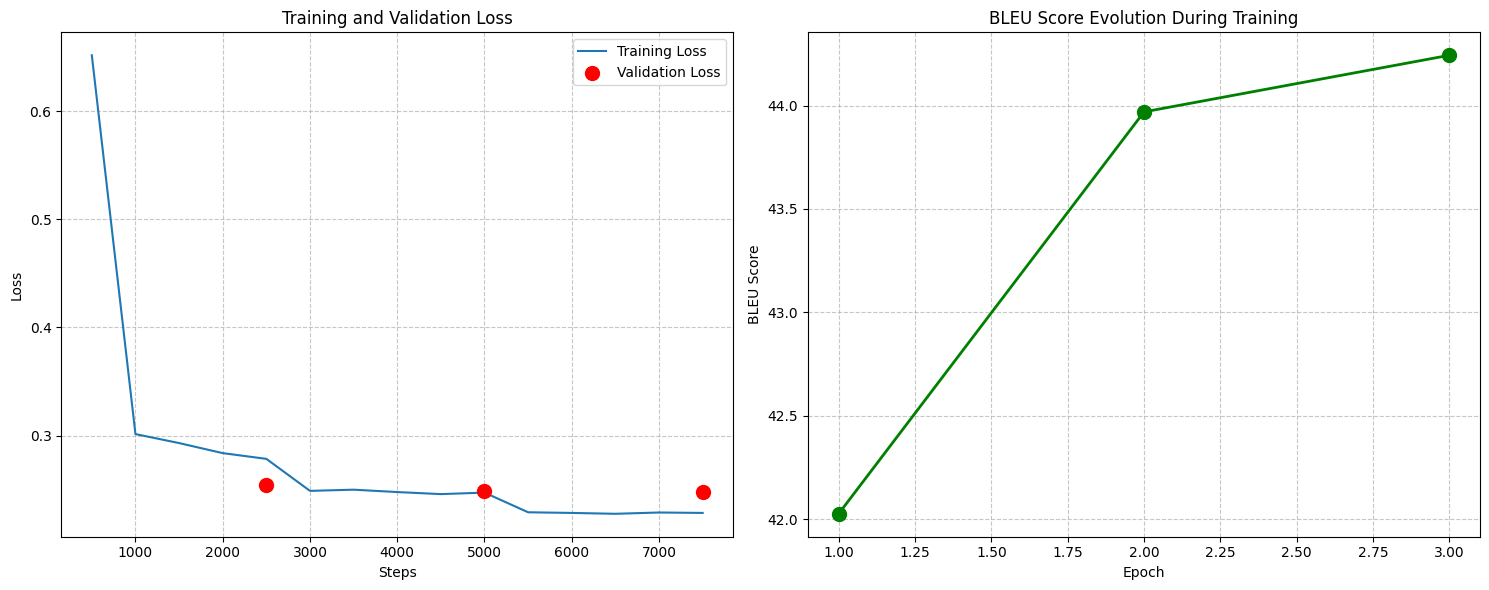

Evaluating translation examples...
== Translation Examples ==

Example 1:
Arabic text: كما صاغ باتسون مصطلح القشوة "إبيستاسيس" لوصف التفاعل الجيني لموقعين مستقلين.
Reference translation: bateson also coined the term "epistasis" to describe the genetic interaction of two independent loci.
Model translation: batson also coined the term "epistasis" to describe the genetic interaction of two independent sites.
--------------------------------------------------

Example 2:
Arabic text: بعد ذلك بوقت قصير اطروحة الأولى المفصلة التي تتناول استخدام تحت الأرض من البوصلات تم نشره من قبل الألمانية عامل Rülein فون Calw (1463-1525).
Reference translation: shortly afterwards the first detailed treatise dealing with the underground use of compasses was published by a german miner rülein von calw (1463–1525).
Model translation: shortly after, the first detailed dissertation dealing with underground use of compasses was published by german worker rülein von calw (1463125).
------------------------------

In [ ]:
# Choosing the Model and Number of epochs
model_choice = "helsinki"
num_epochs = 3
eval_samples = 100

# Ensure Disabling WANDB to avoid issues
import os
os.environ["WANDB_DISABLED"] = "true"

print("============ Start Training Model ============")
trainer, tokenizer, model, test_dataset = main(model_choice, num_epochs, eval_samples)

# Saaving The Final Model
save_path = save_model(tokenizer, model, f"arabic_english_{model_choice}")

# Using the Model For Translation
print("\n============ Transaltion ============")
interactive_translation(tokenizer, model)

In [ ]:
import gradio as gr
tokenizer,model =  load_model('models')

def gradio_translate(arabic_text):
    return translate_text(arabic_text, tokenizer, model)

# Create the Gradio interface
interface = gr.Interface(
    fn=gradio_translate,
    inputs=gr.Textbox(lines=2, placeholder="Enter Arabic text here..."),
    outputs=gr.Textbox(label="English Translation"),
    title="Arabic to English Translator",
    description="Type Arabic text and get the English translation instantly."
)

# Launch the interface
interface.launch()


c:\Users\ysfah\anaconda3\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Model and tokenizer loaded from: models
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
